# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). At the very bottom of the notebook, you'll find some unit tests to check the correctness of your neural network. Be sure to run these before you submit your project.

After you've submitted this project, feel free to explore the data and the model more.



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.rcParams["figure.figsize"] = [10,6]

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [3]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

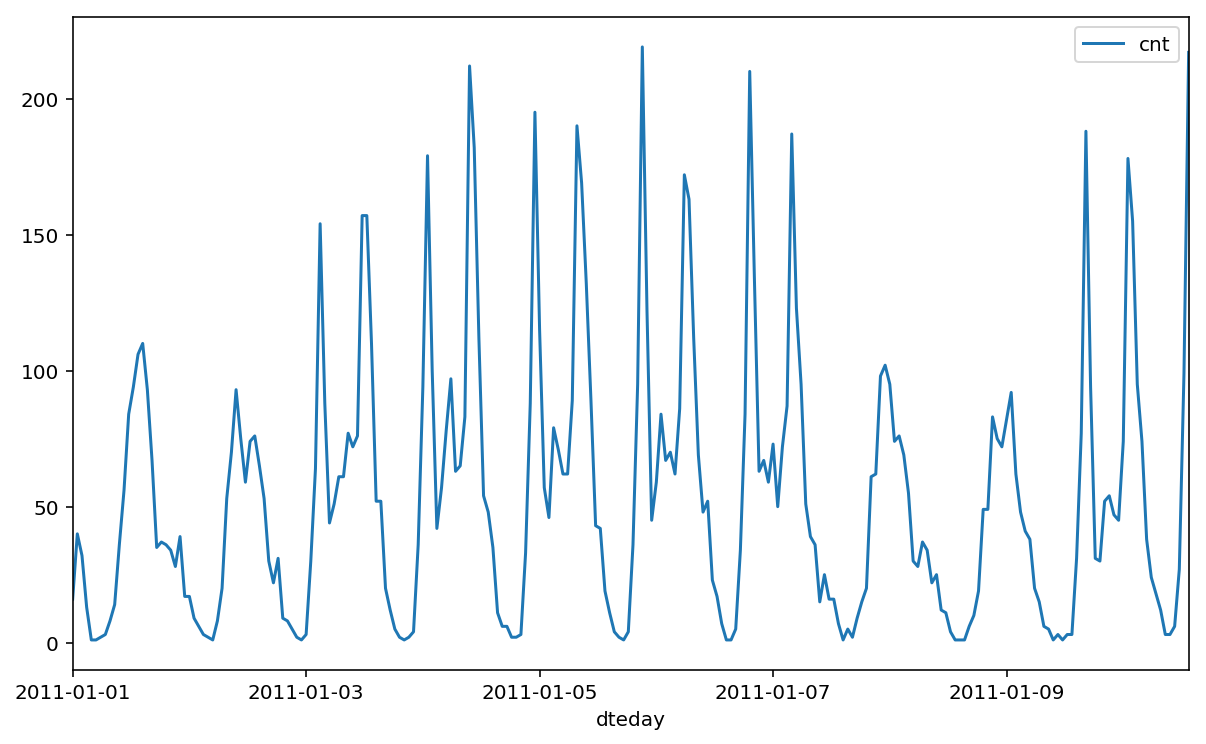

In [5]:
plt.figure(figsize = [10,8])
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. It's important to split the data randomly so all cases are represented in both sets.

In [9]:
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. . You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [81]:
x = tf.placeholder("float", shape = [None, 56])
y = tf.placeholder("float", shape = [None, 1])

# Initialize weights 
W1 = tf.Variable(tf.ones([56, 10]))
b1 = tf.Variable(tf.ones([10]))
W2 = tf.Variable(tf.ones([10, 1]))
b2 = tf.Variable(tf.ones([1]))

# Model
y_hidden = tf.sigmoid(tf.matmul(x, W1) + b1)
y_model = tf.matmul(y_hidden, W2) + b2


# Define the cost function to minimize
loss = tf.reduce_mean(tf.square(y - y_model))
cost = tf.subtract(y, y_model)

# Start our optimizer
optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)

# Start all variables
init = tf.global_variables_initializer()

error = []
# Start the training process
losses = {'train':[], 'validation':[]}
with tf.Session() as sess:
    sess.run(init)
    for i in range(20000):
        _, err = sess.run([optimizer, loss], feed_dict={x: train_features, 
                                                        y: train_targets['cnt'].values.reshape(train_targets.shape[0], -1)})
        
        err_test = sess.run(loss, feed_dict = {x: val_features, 
                                               y: val_targets['cnt'].values.reshape(val_features.shape[0], -1)})
        losses["train"].append(err)
        losses['validation'].append(err_test)
        
        if i % 1000 == 0:
            print "Test Loss at round {0} is {1}".format(i, err)
            print "Validation Loss at round {0} is {1}".format(i, err_test)
            
        
    loss, pred = sess.run([loss, y_model], feed_dict={x: test_features,
                                                     y: test_targets['cnt'].values.reshape(test_targets.shape[0], -1)})
    
    print "the final test loss is {0}".format(loss)
    print "the output is {0}".format(out)

Test Loss at round 0 is 120.797157288
Validation Loss at round 0 is 30.411491394
Test Loss at round 1000 is 0.961452424526
Validation Loss at round 1000 is 1.06253528595
Test Loss at round 2000 is 0.311820030212
Validation Loss at round 2000 is 0.351194918156
Test Loss at round 3000 is 0.252281934023
Validation Loss at round 3000 is 0.283211886883
Test Loss at round 4000 is 0.245001584291
Validation Loss at round 4000 is 0.274067461491
Test Loss at round 5000 is 0.241700649261
Validation Loss at round 5000 is 0.269897222519
Test Loss at round 6000 is 0.241004273295
Validation Loss at round 6000 is 0.267243653536
Test Loss at round 7000 is 0.238208457828
Validation Loss at round 7000 is 0.265407264233
Test Loss at round 8000 is 0.237061277032
Validation Loss at round 8000 is 0.263955771923
Test Loss at round 9000 is 0.236148148775
Validation Loss at round 9000 is 0.262554943562
Test Loss at round 10000 is 0.235305190086
Validation Loss at round 10000 is 0.261409461498
Test Loss at round

In [28]:
val_targets['cnt'].values.reshape(val_features.shape[0], -1).shape

(3375, 1)

## Training the network

Here you'll set the hyperparameters for the network. You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network faster. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. However, it can become too specific to the training set and will fail to generalize to the validation set. This is called overfitting. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [58]:
test_features.shape

(504, 56)

(0, 0.3)

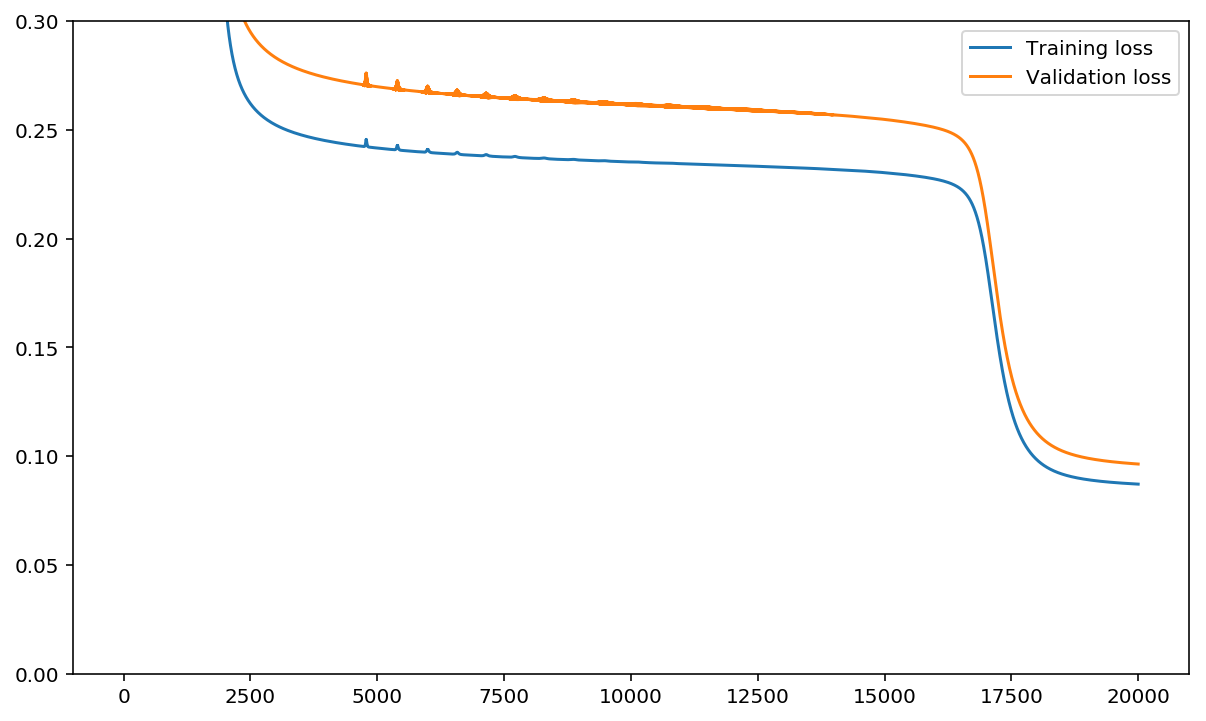

In [78]:
plt.plot(losses['train'], label='Training loss', )
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(0, .3)

## Check out your predictions

Here, use the test data to check that network is accurately making predictions. If your predictions don't match the data, try adjusting the hyperparameters and check to make sure the forward passes in the network are correct.

## Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

The model predicts quite well with the validation loss only 0.0645. The model finds it difficult to predict accurately after Dec 21st as the actual count of bike shares has significantly reduced.

The way we can improve this can be by -
1. Increasing the number of hidden layers. The drawback of that is that we will spend a lot of compute power
2. Generate new features that would help the model identify holiday periods, weekdays and weekends. This way the layers can be trained to predict differently given the type of the day it is.



## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [ ]:
import unittest

np.random.seed(42)
inputs = [0.5, -0.2, 0.1]
targets = [0.4]

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path == 'Bike-Sharing-Dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.train(inputs, targets)
        
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    [ 0.22931895, -1.28754157]))
        
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    [[-0.7128223, 0.22086344, -0.64139849],
                                     [-1.06444693, 1.06268915, -0.17280743]]))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        
        self.assertTrue(np.allclose(network.run(inputs), -0.97900982))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

## Ignore below this point

These are just code chunks that allowed me to develop an intuition about the matrix multiplication and the code's flow. Please ignore these as part of the evaluation.

In [ ]:
#self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
#                                                (self.hidden_nodes, self.input_nodes))
    
#self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
#                                                (self.output_nodes, self.hidden_nodes))


def sigmoid(x, derv = False):
    if derv == False:
        return 1/(1+np.exp(-x))
    else:
        return x*(1-x)

W1 = np.random.normal(0.0, 10**-0.5, (10, 56))
W2 = np.random.normal(0.0, 1**-0.5, (1, 10))

print("Weights input to hidden {0}".format(W1.shape))
print("Weights Hidden to Output {0}".format(W2.shape))


batch = np.random.choice(train_features.index, size=128)
y = train_targets.ix[batch]['cnt'].values
x = train_features.ix[batch].values
print("Train features {0}".format(x.shape))
print("Train targets {0}".format(y.shape))

In [ ]:
hidden_input = np.dot(x, W1.T)
print("hidden_input shape {0}".format(hidden_input.shape))
hidden_output = sigmoid(hidden_input)
print("hidden_output shape {0}".format(hidden_output.shape))

In [ ]:
output = np.dot(hidden_output, W2.T)
print("output shape {0}".format(output.shape))

output_error = y.reshape(y.shape[0], -1) - output
print("output_error shape {0}".format(output_error.shape))

In [ ]:
hidden_error = output_error * W2
print("the hidden_error shape is {0}".format(hidden_error.shape))
hidden_grad = hidden_error * sigmoid(hidden_input, derv = True)
print("the hidden grad is {0}".format(hidden_grad.shape))

In [ ]:
W1n =W1 + np.dot(hidden_grad.T, x)
print("W1 shape is now {0}".format(W1n.shape))

W2n = W2 + np.dot(output_error.T, hidden_output)
print("W2 shape is now {0}".format(W2n.shape))